<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20CWRU%20Dataset%202622.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [64]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F0_Normal.mat


/tmp/ipython-input-4247073321.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['F0_Normal']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F1_Ball_7.mat
['F0_Normal' 'F1_Ball_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F2_Ball_14.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F3_Ball_21.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F4_InnerRace_7.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F5_InnerRace_14.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7'
 'F5_InnerRace_14']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F6_InnerRace_21.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7'
 'F5_InnerRace_14' 'F6_InnerRace_21']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F7_OuterRace_7.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7'
 'F5_InnerRace_14' 'F6_InnerRace_21' 'F7_OuterRace_7']
/content/drive/MyDrive/CWRU_with_NOISE/

# Multi-Kernel Deep 1D-CNN

In [65]:
pip install tensorflow

In [66]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [67]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

Statistical Features

In [68]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2706, STRIDE: 2164
Extracted 2243 rows (target: 1800)
                fault  window      mean       std       rms       max  \
0           F0_Normal       1  0.008517  0.064628  0.065187  0.204443   
1           F0_Normal       2  0.009602  0.063451  0.064174  0.204860   
2           F0_Normal       3  0.010599  0.064361  0.065228  0.211327   
3           F0_Normal       4  0.012741  0.064404  0.065652  0.211536   
4           F0_Normal       5  0.012252  0.061830  0.063032  0.186919   
...               ...     ...       ...       ...       ...       ...   
2238  F9_OuterRace_21     221  0.013152  0.649244  0.649378  4.648259   
2239  F9_OuterRace_21     222  0.012568  0.536755  0.536902  4.377827   
2240  F9_OuterRace_21     223  0.013174  0.685940  0.686067  5.076443   
2241  F9_OuterRace_21     224  0.014050  0.626737  0.626894  3.700912   
2242  F9_OuterRace_21     225  0.011118  0.415185  0.415334  2.776936   

           min  skewness   kurtosis  form_fac

In [69]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
F6_InnerRace_21    226
F5_InnerRace_14    225
F9_OuterRace_21    225
F1_Ball_7          224
F4_InnerRace_7     224
F2_Ball_14         224
F7_OuterRace_7     224
F3_Ball_21         224
F8_OuterRace_14    224
F0_Normal          223
Name: count, dtype: int64
Current rows after equal resampling: 1570
New class distribution:
fault
F0_Normal          157
F7_OuterRace_7     157
F9_OuterRace_21    157
F3_Ball_21         157
F2_Ball_14         157
F1_Ball_7          157
F6_InnerRace_21    157
F5_InnerRace_14    157
F4_InnerRace_7     157
F8_OuterRace_14    157
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [70]:
balanced_df.shape

(1570, 11)

In [71]:
balanced_df=balanced_df.sort_values(by='fault')

In [72]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,F0_Normal,43,0.009751,0.065139,0.065864,0.212996,-0.215708,-0.274433,-0.045461,1.236035,3.233858
1165,F0_Normal,36,0.011293,0.062924,0.063929,0.186711,-0.168561,-0.184237,-0.387789,1.219560,2.920578
1143,F0_Normal,54,0.012011,0.065607,0.066698,0.229060,-0.212788,-0.250128,-0.149889,1.231087,3.434300
1132,F0_Normal,34,0.010876,0.066891,0.067769,0.205069,-0.223218,-0.129397,-0.125704,1.245186,3.025978
1124,F0_Normal,124,0.007138,0.064205,0.064601,0.184625,-0.201522,-0.142130,-0.294445,1.226859,2.857937
...,...,...,...,...,...,...,...,...,...,...,...
60,F9_OuterRace_21,119,0.012091,0.590053,0.590177,4.476317,-4.531405,-0.231919,21.559533,2.147469,7.584706
503,F9_OuterRace_21,20,0.016847,0.564573,0.564825,4.379496,-5.038048,-1.139300,25.857851,2.183795,7.753727
171,F9_OuterRace_21,83,0.013734,0.547218,0.547391,2.989776,-3.105795,-0.225552,8.289343,1.751785,5.461870
804,F9_OuterRace_21,213,0.016183,0.589297,0.589519,3.952147,-4.732560,-0.793820,17.741390,1.972937,6.704016


     t-SNE 1    t-SNE 2      fault
0  21.613050 -26.728163  F0_Normal
1  22.808825 -25.681459  F0_Normal
2  37.245319  26.502666  F0_Normal
3  35.264088  27.822409  F0_Normal
4  25.049288 -23.235119  F0_Normal


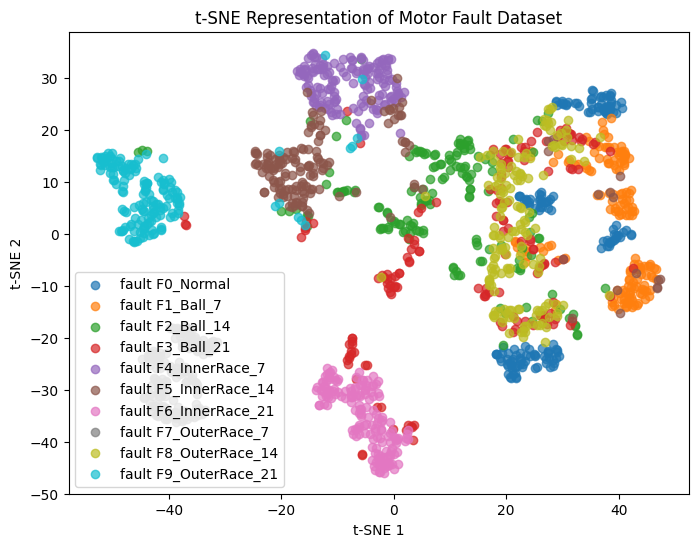

In [73]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


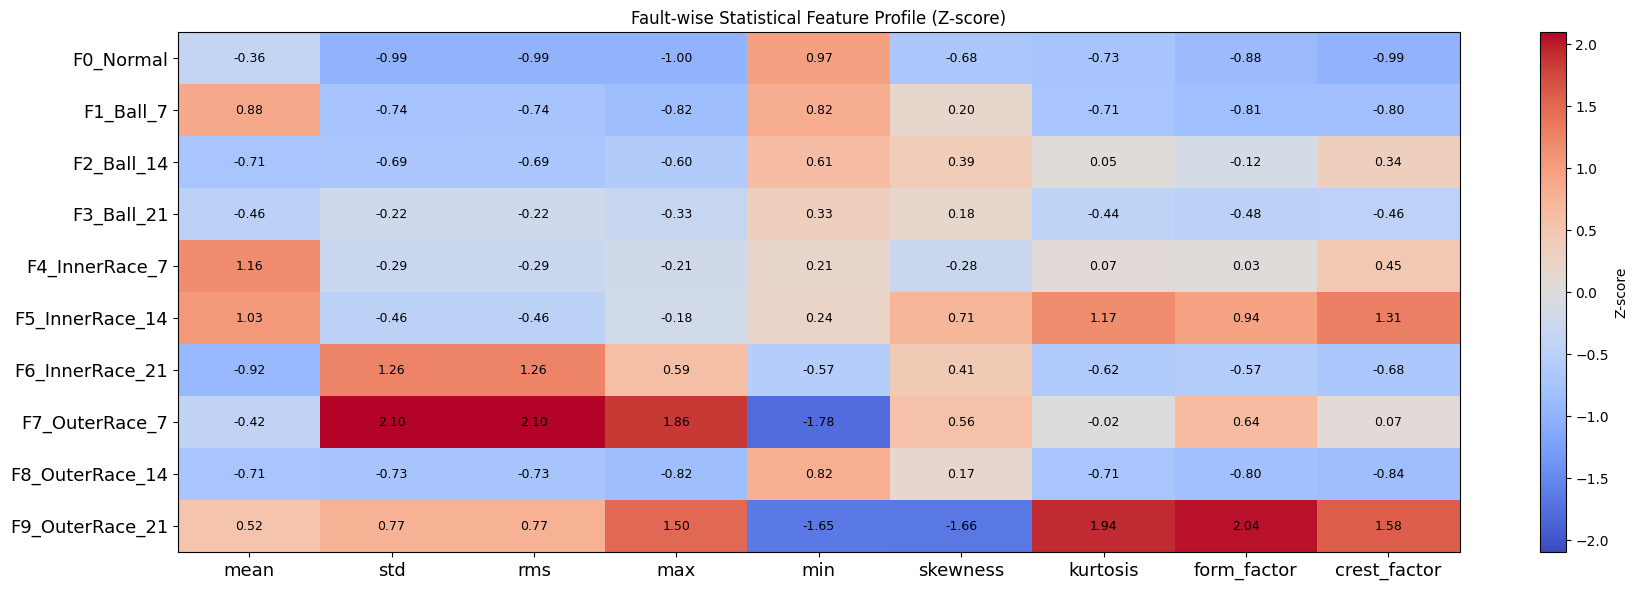

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Define fault_profile_z by grouping the normalized features by fault type
feature_columns_for_profile = [col for col in STAT_Motor_Fault_dataset_normalized.columns if col not in ['fault', 'window']]
fault_profile_z = STAT_Motor_Fault_dataset_normalized.groupby('fault')[feature_columns_for_profile].mean()

vals = fault_profile_z.values
vmax = np.max(np.abs(vals))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

plt.figure(figsize=(18, 6))
im = plt.imshow(
    vals,
    aspect="auto",
    cmap="coolwarm",
    norm=norm
)
plt.colorbar(im, label="Z-score")

plt.xticks(
    range(len(fault_profile_z.columns)),
    fault_profile_z.columns,
    rotation=0,
    ha="center",
    fontsize=13
)

plt.yticks(
    range(len(fault_profile_z.index)),
    fault_profile_z.index,
    fontsize=13
)

plt.title("Fault-wise Statistical Feature Profile (Z-score)")

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        plt.text(
            j, i,
            f"{vals[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=9,
            color="black"
        )

plt.tight_layout()
plt.savefig(
    "Faultwise_Statistical_Feature_Profile_Zscore.png",
    dpi=600,
    bbox_inches="tight"
)
plt.show()

In [75]:
feature_cols = [c for c in balanced_df.columns if c not in ["fault", "window"]]

def pick_representative(df):
    mean_vec = df[feature_cols].mean()
    dist = ((df[feature_cols] - mean_vec) ** 2).sum(axis=1)
    return df.loc[dist.idxmin()]

one_sample_per_fault = (
    balanced_df
    .groupby("fault", group_keys=False)
    .apply(pick_representative)
    .reset_index(drop=True)
)

one_sample_per_fault


/tmp/ipython-input-69028754.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_representative)


,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,F0_Normal,153,0.014218,0.064056,0.065615,0.208824,-0.241577,-0.160111,-0.112313,1.233644,3.182578
1,F1_Ball_7,42,0.015592,0.134940,0.135838,0.467716,-0.449775,-0.016581,0.030428,1.253476,3.443188
2,F2_Ball_14,215,0.009162,0.176940,0.177177,0.889536,-0.779387,0.130501,4.354587,1.479094,5.020593
3,F3_Ball_21,137,0.011607,0.311298,0.311514,1.271094,-1.221026,0.084412,1.293100,1.326280,4.080371
4,F4_InnerRace_7,48,0.019331,0.292051,0.292690,1.536661,-1.455092,-0.140196,4.408726,1.448742,5.250136
5,F5_InnerRace_14,44,0.016070,0.211351,0.211961,1.363011,-1.212353,0.031167,10.805986,1.656102,6.430486
6,F6_InnerRace_21,86,0.009626,0.780075,0.780134,2.754558,-2.775210,0.046137,0.449895,1.286078,3.530876
7,F7_OuterRace_7,19,0.011944,1.010257,1.010328,4.768451,-4.674551,0.044564,3.956857,1.580127,4.719705
8,F8_OuterRace_14,128,0.011494,0.142340,0.142804,0.482527,-0.473348,-0.003098,-0.010896,1.253774,3.378960
9,F9_OuterRace_21,159,0.016516,0.629738,0.629954,4.220909,-4.700008,-0.301818,15.143431,1.883859,6.700341
